# Simple classification and regression tutorial

In this section we will cover the basic API of PyTorch network models and use it to create first a simple logistic regression trained on simulated data. Following this we will train an multi-layer perceptron (MLP) followed by a simple convolutional neural network to perform classification of the MNIST dataset.

First load basic modules


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")


## GPU or CPU?

Before we can even begin, we need to know whether we are using a GPU or a CPU. If its the former, the model and all the data should be uploaded into the GPU. Fortunately, we can define a variable "device" that will either be cpu or gpu depending on availability, and load the data automatically on the correct 'device'.

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device) 

cpu


We see that if cuda is available our model will be run on a GPU, otherwise the model will need to run on CPU.

## Defining a network class

We can define a class network in pytorch, in two steps, by inheriting `nn.Module` :

1. The first part is creation of the constructor `__init__` in which you must define all parameters and layers that you will use
2. The second part is to define the forward pass through the function `forward(self,x)` which takes in input and calculates the output.

Note, backpropagation is automatically defined by autograd and this does not need to be explicitely coded up.
Once complete, you can then create an instance of the class using `net = Model()`. 

Example:

In [20]:
class Model(nn.Module):
 def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.fc1 = nn.Linear(320, 10)

def forward(self, x):
       x = F.relu(self.conv1(x))
       x = F.relu(self.conv2(x))
       x = x.view(-1, 320)
       x = F.relu(self.fc1(x))
       return F.log_softmax(x)

net = Model()


This network contains 2 convolutional layers, and one fully connected layer.
The first convolution has a kernel of [5x5] takes an 2D image with 3 channels, and outputs 64 channels. 
Once the input goes through 2 passes of convolution and non-linear activation (ReLu), it is reshaped using `x.view(-1, 320)`, which allows it to be fed into the final FC layer (which expects a vector). Before you send the output, you will use the softmax activation function.

### Loss Function
The loss function is used to measure how well the prediction model is able to predict the expected results. PyTorch already has many standard loss functions in the torch.nn module. For example, you can use the Cross-Entropy Loss to solve a multi-class classification problem, or a mean squared error (MSE) loss for regression. 

For example, to define the loss function and compute the losses:

```python
loss_CE = nn.CrossEntropyLoss()
loss_MSE = nn.MSELoss()

#training process
loss = loss_CE(prediction, target)
```

### Optimizer
There are many optmizers available in pytorch - see https://pytorch.org/docs/stable/optim.html for full list and further examples.

You define an optmizer in the following way:

```python
optim = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
```


### Backprop and clearing gradients
To perform the backpropagation, you call the loss.backward(), followed by optim.step(). **You should clear gradients before every training iteration to ensure there's no gradients remaining**. This is to avoid mixing up gradients between minibatches. More specifically however, it is an sideeffect of the fact that PyTorch implements dynamic computation graphs as opposed to static ones (like tensorflow). In addition, the fact that the backward() function in Pytorch accumulates gradients is useful for Recurrent Neural Networks and complex networks with multiple different parts.

```python
net.zero_grad() # to clear the existing gradient - this should be done prior to a training pass
optim.zero_grad() # to clear gradient in optimizer - this is equivalent to net.zero_grad(). 
loss.backward() # to perform backpropragation - accumulates the gradient (by addition) for each parameter
optim.step() # optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule. 
```

## Simple Regression with PyTorch - Predicting a Simple Function

### Creating a simple neural network

We will now go through an example of how to create, train and test a PyTorch implementation of logistic regression (single layer neural network). It takes an input of size [1] and outputs also size [1].


In [21]:

class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)

   def forward(self, x):
       x = self.layer(x)      
       return x

net = Net()
print(net)


Net(
  (layer): Linear(in_features=1, out_features=1, bias=True)
)


### Simulate data using a simple function

We can create simulated data to test our simple regression network. The aim is to use our neural network to estimate/ make predictions. 

We use the following function to randomly generate 100 data points:

$Y = \cos(x) \times x^3 + 4x + 0.6 \times rand()$



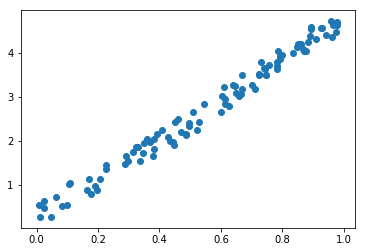

In [22]:
# Visualize our data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.random.rand(100)
y = np.cos(x) * np.power(x,3) + 4*x + np.random.rand(100)*0.6

plt.scatter(x, y)
plt.show()


Since we're using pytorch, we need to convert our numpy array to a pytorch tensor. The size of the input will be [100, 1], where 100 is the batch size, and 1 is the size of the input (as previously defined in our neural network).

In [23]:
# convert numpy array to tensor in shape of input size
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()
print(x.size(), y.size())


torch.Size([100, 1]) torch.Size([100, 1])


### Define the optmizer and loss function

We next define our optimizer and loss function. Since we are performing regression, the loss function we chose is Mean Squared Error, or l2 loss. Another common loss function for regression is the Mean Absolute Error, or l1 loss.


In [24]:
# Define Optimizer and Loss Function
#------------------------------------------------------task 1----------------------------------------------------------------
# Task 1: change optimizer here
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
# Task 1: change loss function here
loss_func = torch.nn.MSELoss()
loss_func = torch.nn.L1Loss()
#----------------------------------------------------------------------------------------------------------------------------


### Training

During training we iterate through our data. Here we use number of epochs = 200, but the optimal number largely depends on the dataset and the task.


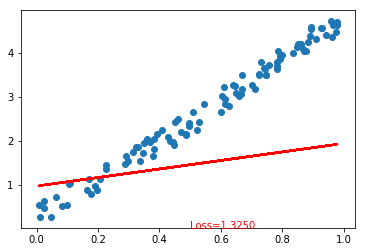

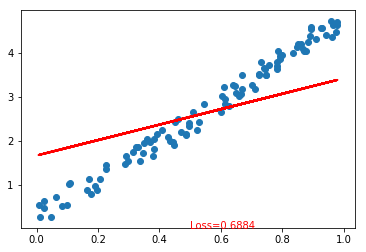

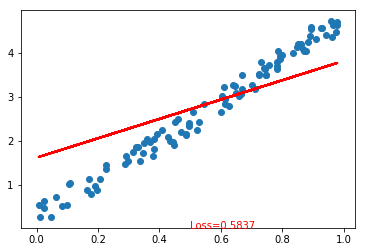

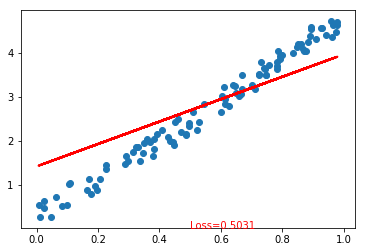

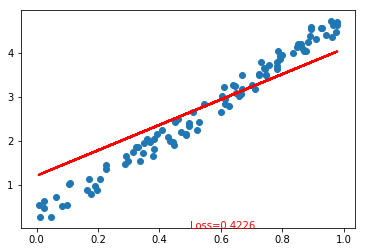

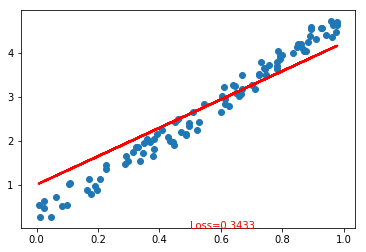

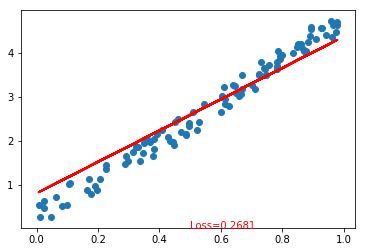

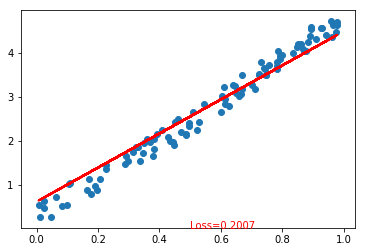

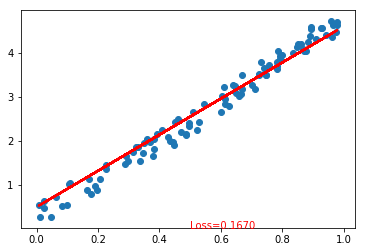

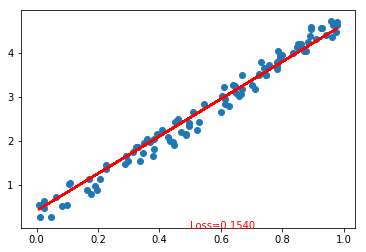

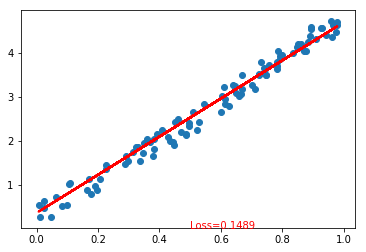

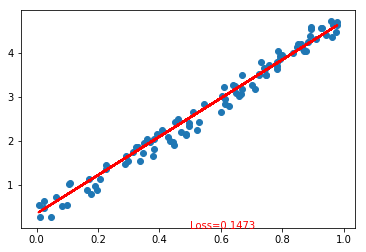

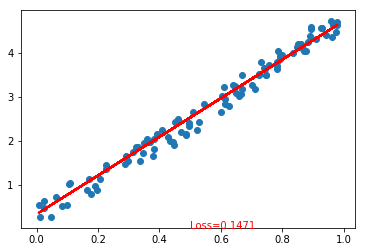

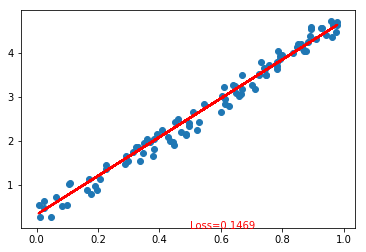

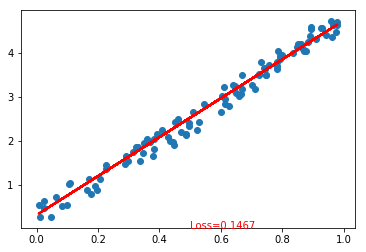

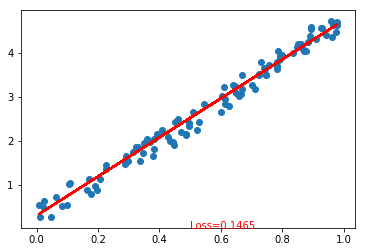

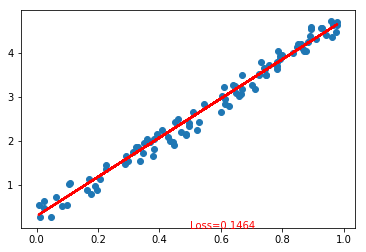

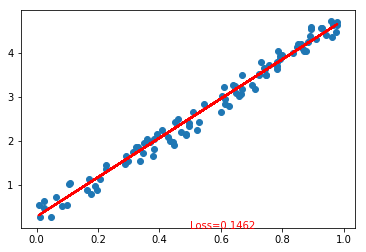

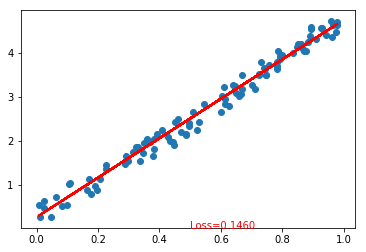

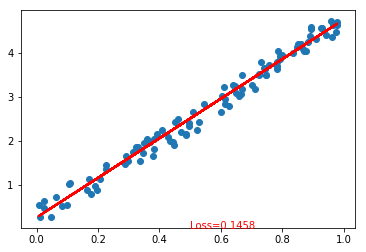

In [25]:
inputs = x 
outputs = y 
epochs = 200
for i in range(epochs):
    optimizer.zero_grad() # clear gradients - here we could interchangibly use net.zero_grad()
    prediction = net(inputs) # pass data through network
    loss = loss_func(prediction, outputs) # compute loss  
    loss.backward() # accumulate gradients       
    optimizer.step() # update network parameters

    # Display results
    if i % 10 == 0:
        # note how we need to tranform data back to numpy
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=2)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
        plt.pause(0.1)



### Result

We have now set up and performed simple regression with a neural network. You can see the results above, how in every iteration the red line (the prediction) updates, and moves closer to fit the data.

**You can perform regression with any neural network- the important step to remember is that your final layer should be of output size [1], and the loss function you use is suitable for regression - e.g. mean squared error, absolute sqaured error**

### Task 1

1. change the loss function to Mean Absolute Error (l1 loss) - which loss function work better?
2. change the optimiser?

## Image Classification with PyTorch - Handwritten Digit Class Prediction

A very common dataset to learn the basics of deep learning, and even to validate new methods is with the MNIST dataset.
The dataset is a set of 60,000 images of handwritten numbers between 0 - 9, of size [28,28] pixels, with labels.

Here is an example of images from the dataset:

![mnist](mnist.png)



### Loading the data

We again load the data - but this time using Torchvision - a library that comes with pytorch, that helps with dataloading, training and data transforms (e.g. like resizing, or normalizing the image).



In [26]:
import torchvision
import numpy as np
from torchvision import datasets, models, transforms

# This is used to transform the images to Tensor and normalize it
transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

training = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=8,
                                         shuffle=True, num_workers=2)

testing = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=8,
                                        shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')


The transform function converts the images into tensor and normalizes the value. The function torchvision.transforms.MNIST, will download the dataset (if it's not available) in the directory, set the dataset for training if necessary and do the transformation process.

To visualize the dataset, you use the data_iterator to get the next batch of images and labels. You use matplot to plot these images and their appropriate label. As you can see below our images and their labels.

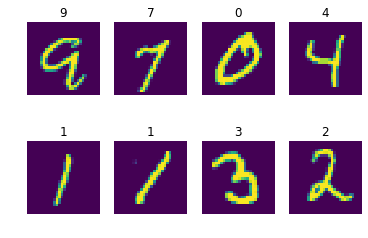

In [27]:
#create an iterator for train_loader
# get random training images
data_iterator = iter(train_loader)
images, labels = data_iterator.next()
images = images.to(device)
labels = labels.to(device)
#display 8 images from the dataset
rows = 2
columns = 4
fig=plt.figure()
for i in range(8):
    fig.add_subplot(rows, columns, i+1)
    plt.title(classes[labels[i]])
    plt.axis('off')
    img = images[i] / 2 + 0.5 # this is for unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu()) # tranform tensor to image with torchvision
    plt.imshow(img)
plt.show()


### Create your neural network

We next make a simple neural network for image classification. We create a network with 2 convolutional layers with max pooling and relu non-linearities. The output size = [10], since we have 10 classes, and is followed by a softmax layer to ensure the result is a set of probabilities for each class. Softmax is very commonly used as the last layer in classification tasks.

Note that we also introduce a new way to define a model - using **sequential model**. This is often a **preferred** option if is possible, since it runs faster. 


In [29]:
import torch.nn as nn

# flatten the tensor into 
class Flatten(nn.Module):
   def forward(self, input):
       return input.view(input.size(0), -1)

#sequential based model
seq_model = nn.Sequential(
           nn.Conv2d(1, 10, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Dropout2d(),
           nn.Conv2d(10, 20, kernel_size=5),
           nn.MaxPool2d(2),
           nn.ReLU(),
           Flatten(),
           nn.Linear(320, 50),
           nn.ReLU(),
           nn.Linear(50, 10),
           nn.Softmax(),
         )

net = seq_model
print(net)
net = net.to(device)

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten()
  (8): Linear(in_features=320, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=10, bias=True)
  (11): Softmax(dim=None)
)


### Loss function and optimizer

We again need to define our loss and optimizers. In this case, since we're doing classification, we use **CrossEntropy Loss**, a commonly used loss function for classification.


In [30]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



### Training 

We will now train our classifer model - this time iterating using enumerate. 

### Task 2 

Implement the training interations - see example from regression task

At each epoch, as before we need to clear gradients first (since they are accumalated at each backward step), then we pass the data through the network to make a prediction, compute loss and gradiets, and finally update the parameters.


In [31]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # Task 2: implement training iteration here
        # clear the gradient
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = net(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[1,     1] loss: 2.300
[1,    11] loss: 2.298
[1,    21] loss: 2.304
[1,    31] loss: 2.307
[1,    41] loss: 2.302
[1,    51] loss: 2.298
[1,    61] loss: 2.304
[1,    71] loss: 2.304
[1,    81] loss: 2.301
[1,    91] loss: 2.307
[1,   101] loss: 2.308
[1,   111] loss: 2.299
[1,   121] loss: 2.307
[1,   131] loss: 2.303
[1,   141] loss: 2.298
[1,   151] loss: 2.307
[1,   161] loss: 2.304
[1,   171] loss: 2.301
[1,   181] loss: 2.306
[1,   191] loss: 2.304
[1,   201] loss: 2.300
[1,   211] loss: 2.304
[1,   221] loss: 2.300
[1,   231] loss: 2.295
[1,   241] loss: 2.302
[1,   251] loss: 2.295
[1,   261] loss: 2.293
[1,   271] loss: 2.307
[1,   281] loss: 2.304
[1,   291] loss: 2.305
[1,   301] loss: 2.298
[1,   311] loss: 2.304
[1,   321] loss: 2.300
[1,   331] loss: 2.301
[1,   341] loss: 2.298
[1,   351] loss: 2.300
[1,   361] loss: 2.297
[1,   371] loss: 2.308
[1,   381] loss: 2.301
[1,   391] loss: 2.300
[1,   401] loss: 2.292
[1,   411] loss: 2.306
[1,   421] loss: 2.292
[1,   431] 

[1,  3581] loss: 1.643
[1,  3591] loss: 1.678
[1,  3601] loss: 1.791
[1,  3611] loss: 1.759
[1,  3621] loss: 1.645
[1,  3631] loss: 1.876
[1,  3641] loss: 1.808
[1,  3651] loss: 1.737
[1,  3661] loss: 1.886
[1,  3671] loss: 1.983
[1,  3681] loss: 1.945
[1,  3691] loss: 1.724
[1,  3701] loss: 1.935
[1,  3711] loss: 1.684
[1,  3721] loss: 2.073
[1,  3731] loss: 1.656
[1,  3741] loss: 1.730
[1,  3751] loss: 1.791
[1,  3761] loss: 1.840
[1,  3771] loss: 1.676
[1,  3781] loss: 1.818
[1,  3791] loss: 1.752
[1,  3801] loss: 1.978
[1,  3811] loss: 2.040
[1,  3821] loss: 2.051
[1,  3831] loss: 2.039
[1,  3841] loss: 1.962
[1,  3851] loss: 1.906
[1,  3861] loss: 1.734
[1,  3871] loss: 1.684
[1,  3881] loss: 1.931
[1,  3891] loss: 1.651
[1,  3901] loss: 1.855
[1,  3911] loss: 1.784
[1,  3921] loss: 2.011
[1,  3931] loss: 1.595
[1,  3941] loss: 1.617
[1,  3951] loss: 1.784
[1,  3961] loss: 1.651
[1,  3971] loss: 1.929
[1,  3981] loss: 1.896
[1,  3991] loss: 1.722
[1,  4001] loss: 1.911
[1,  4011] 

[1,  7151] loss: 1.572
[1,  7161] loss: 1.831
[1,  7171] loss: 1.836
[1,  7181] loss: 1.560
[1,  7191] loss: 1.463
[1,  7201] loss: 1.602
[1,  7211] loss: 1.619
[1,  7221] loss: 1.757
[1,  7231] loss: 1.601
[1,  7241] loss: 1.591
[1,  7251] loss: 1.525
[1,  7261] loss: 1.512
[1,  7271] loss: 1.614
[1,  7281] loss: 1.885
[1,  7291] loss: 1.597
[1,  7301] loss: 1.706
[1,  7311] loss: 1.590
[1,  7321] loss: 1.613
[1,  7331] loss: 1.702
[1,  7341] loss: 1.480
[1,  7351] loss: 1.625
[1,  7361] loss: 1.733
[1,  7371] loss: 1.590
[1,  7381] loss: 1.477
[1,  7391] loss: 1.472
[1,  7401] loss: 1.751
[1,  7411] loss: 1.589
[1,  7421] loss: 1.594
[1,  7431] loss: 1.593
[1,  7441] loss: 1.482
[1,  7451] loss: 1.583
[1,  7461] loss: 1.711
[1,  7471] loss: 1.826
[1,  7481] loss: 1.711
[1,  7491] loss: 1.900


### Testing

We will now use our trained network to make a prediction on our test set. 


In [32]:
#make an iterator from test_loader
test_iterator = iter(test_loader)
#Get a batch of testing images
images, labels = test_iterator.next()
images = images.to(device)
labels = labels.to(device)

Predicted:      7     2     1     0     4     1     4     9


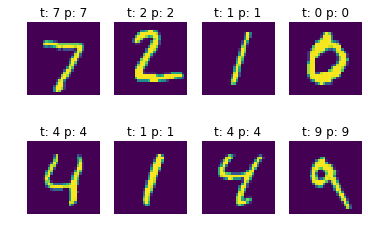

In [35]:
y_score = net(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))

# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


### Computing classification scores

We will now use the predictions to compute the accuracy, f1 score, precision and recall. These are scores commonly used to evaluate classification, in particular the f1 score is a good measure for datasets with imbalanced classes.

In [36]:
# first convert tensors to numpy
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

You can use sklearn classification metrics to calculate the scores - you will need to input the true labels, and predicted classes.

See https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics for more details.

In [37]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 1.0 , f1 score: 1.0 , precision: 1.0 , recall: 1.0


## ResNet with pytorch

ResNet was first introduced in 2016 as a way to deal with the gradient vanishing problem. This can occur when the network is too deep, and the gradients shrink to zero after a few back propagation steps. This can result in the parameter weights not being updated, since the gradient is zero.

ResNets can counter this problem by allowing the gradients to flow directly backwards, by adding the additive resnet connections.

An example of a resnet block is illustrated below:

![resnet-block](resnet-block.png)
source: https://d2l.ai/chapter_convolutional-modern/resnet.html

He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

http://www.pabloruizruiz10.com/resources/CNNs/ResNet-PyTorch.html

https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8


### Using existing ResNet 

It's possible to load existing networks using pytorch library torchvision - you can load these models using torchvision.models, which contains networks such as ResNet, Alexnet, VGG, Densenet, etc...
https://pytorch.org/docs/stable/torchvision/models.html

For example the following pretrained resnets models can be loaded in Pytorch:
```python
torchvision.models.resnet18(pretrained=True, **kwargs)
```

You can also load a model that hasn't been pretrained in the following way:
```python
torchvision.models.resnet18(pretrained=False, **kwargs)
```

You can find examples of how to use pretrained models in: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

However, you will find that using a pretrained model doesn't always suit your needs. For example, the resnet models shown above have been trained on RGB images (i.e. they are 3 channels), which means that you can't use them without adjustment on grayscale images, or on 3D medical data.


### Create custom ResNet layers 

We will therefore now cover how to create a custom ResNet layer that be used to build custom deep neural networks.

A resnet block (implemented as the BasicBlock class below) has the following steps:
1. Convolution, followed by batchnorm, followed by relu
2. Convolution, followed by batchnorm 
3. shortcut step, added to the output of the convolutions
4. relu

### Task 3 - implement the forward pass of the BasicBlock

All the layers have been initialized in the code below.
Implement a forward pass through the BasicBlock. 


In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        #-----------------------------------------------------task 3 -----------------------------------------------------
        # Task 3: implement a forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        #-----------------------------------------------------------------------------------------------------------------
        return out


In [18]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18(in_channels=1):
    return ResNet(BasicBlock, [2,2,2,2], in_channels=in_channels)



## Use ResNet for classification - MNIST

### Task 4 - run ResNet on MNIST for classification
Create a ResNet network and run with the same code as above for classification, and then test.
Remember to define your loss function, optimizer, dataloaders, and your resnet network. 
Then run the training and testing, as before.



In [60]:
#-----------------------------------------------------task 4 -----------------------------------------------------
# Task 4: Train and test ResNet on MNIST dataset for classification
# hints: define your resnet network, loss function, optimizer and dataloaders. 
# Then you can run the same training and testing code as above.
# ----------------------------------------------------------------------------------------------------------------

In [19]:
import torch.optim as optim

resnet = ResNet18(in_channels=1)
resnet = resnet.to(device)

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)

optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [20]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        data = data.to(device)
        labels = labels.to(device)
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = resnet(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.269
[1,    11] loss: 2.258
[1,    21] loss: 2.323
[1,    31] loss: 1.881
[1,    41] loss: 1.845
[1,    51] loss: 1.454
[1,    61] loss: 1.566
[1,    71] loss: 1.293
[1,    81] loss: 1.381
[1,    91] loss: 1.501
[1,   101] loss: 1.116
[1,   111] loss: 1.068
[1,   121] loss: 0.744
[1,   131] loss: 1.017
[1,   141] loss: 0.697
[1,   151] loss: 0.717
[1,   161] loss: 0.421
[1,   171] loss: 0.786
[1,   181] loss: 0.442
[1,   191] loss: 1.313
[1,   201] loss: 0.974
[1,   211] loss: 0.419
[1,   221] loss: 0.342
[1,   231] loss: 0.369
[1,   241] loss: 0.158
[1,   251] loss: 0.357
[1,   261] loss: 0.272
[1,   271] loss: 0.548
[1,   281] loss: 0.316
[1,   291] loss: 0.362
[1,   301] loss: 0.282
[1,   311] loss: 0.338
[1,   321] loss: 0.809
[1,   331] loss: 0.434
[1,   341] loss: 0.257
[1,   351] loss: 0.174
[1,   361] loss: 0.883
[1,   371] loss: 0.107
[1,   381] loss: 0.063
[1,   391] loss: 0.106
[1,   401] loss: 0.327
[1,   411] loss: 0.044
[1,   421] loss: 0.156
[1,   431] 

[1,  3571] loss: 0.034
[1,  3581] loss: 0.005
[1,  3591] loss: 0.009
[1,  3601] loss: 0.014
[1,  3611] loss: 0.082
[1,  3621] loss: 0.066
[1,  3631] loss: 0.027
[1,  3641] loss: 0.123
[1,  3651] loss: 0.002
[1,  3661] loss: 0.010
[1,  3671] loss: 0.016
[1,  3681] loss: 0.635
[1,  3691] loss: 0.006
[1,  3701] loss: 0.019
[1,  3711] loss: 0.021
[1,  3721] loss: 0.205
[1,  3731] loss: 0.024
[1,  3741] loss: 0.441
[1,  3751] loss: 0.042
[1,  3761] loss: 0.006
[1,  3771] loss: 0.054
[1,  3781] loss: 0.017
[1,  3791] loss: 0.008
[1,  3801] loss: 0.041
[1,  3811] loss: 0.017
[1,  3821] loss: 0.476
[1,  3831] loss: 0.036
[1,  3841] loss: 0.239
[1,  3851] loss: 0.046
[1,  3861] loss: 0.081
[1,  3871] loss: 0.231
[1,  3881] loss: 0.202
[1,  3891] loss: 0.005
[1,  3901] loss: 0.025
[1,  3911] loss: 0.013
[1,  3921] loss: 0.003
[1,  3931] loss: 0.007
[1,  3941] loss: 0.010
[1,  3951] loss: 0.013
[1,  3961] loss: 0.126
[1,  3971] loss: 0.002
[1,  3981] loss: 0.039
[1,  3991] loss: 0.009
[1,  4001] 

[1,  7141] loss: 0.002
[1,  7151] loss: 0.458
[1,  7161] loss: 0.851
[1,  7171] loss: 0.018
[1,  7181] loss: 0.002
[1,  7191] loss: 1.118
[1,  7201] loss: 0.013
[1,  7211] loss: 0.004
[1,  7221] loss: 0.009
[1,  7231] loss: 0.002
[1,  7241] loss: 0.003
[1,  7251] loss: 0.005
[1,  7261] loss: 0.001
[1,  7271] loss: 0.073
[1,  7281] loss: 0.111
[1,  7291] loss: 0.006
[1,  7301] loss: 0.052
[1,  7311] loss: 0.003
[1,  7321] loss: 0.015
[1,  7331] loss: 0.307
[1,  7341] loss: 0.005
[1,  7351] loss: 0.005
[1,  7361] loss: 0.179
[1,  7371] loss: 0.027
[1,  7381] loss: 0.479
[1,  7391] loss: 0.012
[1,  7401] loss: 1.045
[1,  7411] loss: 0.020
[1,  7421] loss: 0.044
[1,  7431] loss: 0.032
[1,  7441] loss: 0.244
[1,  7451] loss: 0.113
[1,  7461] loss: 0.004
[1,  7471] loss: 0.588
[1,  7481] loss: 0.009
[1,  7491] loss: 0.110


Predicted:      7     2     1     0     4     1     4     9


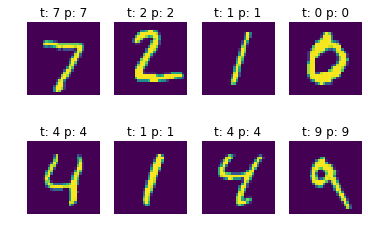

In [21]:
#make an iterator from test_loader
#Get a batch of testing images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

images = images.to(device)
labels = labels.to(device)

y_score = resnet(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))

# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


In [22]:
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

In [23]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 1.0 , f1 score: 1.0 , precision: 1.0 , recall: 1.0


## References

This tutorial was inspired by https://www.guru99.com/pytorch-tutorial.html
